# Income Analysis

This project aims to use a dataset of incomes of adults from the 1994 Census to create models that can be used to predict whether an individual makes an annual income of greater than 50,000 or not based on characteristics about the individual. Various supervised learning models will be explored to determine how these models perform on this classification task.

The goal of the project is to determine which sociodemographic characteristics about an individual have an influence on their annual income and by how much these characteristics influence the annual income. Doing so could provide insights into social inequalities regarding an individual's income.

# Dataset

The dataset used for this project is titled "Adult" and is from the University of California Irvine's Machine Learning Repository.

Becker, B., & Kohavi, R. (1996). Adult. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20

In [1]:
import pandas as pd

data = pd.read_csv('./data/raw_data.csv')
print(data.shape)

(48842, 15)


The dataset contains information on adults from the 1994 Census. The dataset includes information on 48,842 individuals with 15 columns.

### Target Variable

The target variable in this analysis is the "income" variable. This categorical variable indicates whether an individual's income is greater than 50,000 or not.

### Feature Variables

age (numerical) - Age

workclass (categorical) - Type of work

fnlwgt (numerical) - Final weight of observation

education (categorical) - Highest level of education

education-num (numerical) - Number assigned based on "education" feature

marital-status (categorical) - Marital status

occupation (categorical) - Industry/role

relationship (categorical) - Relationship relative to marital status

race (categorical) - Race

sex (categorical) - Sex

capital-gain (numerical) - Capital gain

capital-loss (numerical) - Capital loss

hours-per-week (numerical) - Average number of hours worked per week

native-country (categorical) - Country of birth

# Data Cleaning

### Missing Values

The UCI Machine Learning Repository website's page for this dataset mentions that there are missing values in the columns "workclass", "occupation", and "native-country".

In [2]:
missing_values_columns = ['workclass', 'occupation', 'native-country']
for column in missing_values_columns:
    print(f'{column} has missing values: {data[column].isnull().any()}')

workclass has missing values: True
occupation has missing values: True
native-country has missing values: True


These columns do indeed have missing values. For this project, it is best to drop any rows that contain missing values in any of the columns.

In [3]:
print(data.shape)
data = data.dropna()
print(data.shape)

(48842, 15)
(47621, 15)


1,221 rows were dropped since they had missing values.

In [4]:
categorical_vars = data.select_dtypes(exclude='number').columns
for var in categorical_vars:
    print(f'{var}:', data[var].unique())

workclass: ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
education: ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
marital-status: ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
occupation: ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']
relationship: ['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']
race: ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
sex: ['Male' 'Female']
native-country: ['United-States' 'Cuba' 'Jamaica' 'India' '?' 'Mexico' 'South'
 'Puerto-Rico' 'Honduras' 'England' '

The "workclass", "occupation", and "native-country" columns still contain values that are the string "?". Rows containing this value in these columns should also be dropped.

In [5]:
data = data[~(data == '?').any(axis=1)]
print(data.shape)

(45222, 15)


An additional 2,399 rows were dropped.

### Dropping Features

The "education" categorical variable may be redundant because of the "education-num" numerical variable.

In [6]:
print(len(data['education'].unique()))
print(data['education-num'].min(), data['education-num'].max())

16
1 16


There are 16 unique values in the "education" column and the "education-num" column contains integers from 1 to 16. This suggests that the "education" variable can be dropped since it is an ordinal variable and its information is already captured as integers in "education-num".

In [7]:
data = data.drop(columns='education')

The "fnlwgt" column can also be dropped since it is not helpful when building models in this project.

In [8]:
data = data.drop(columns='fnlwgt')

### Data Munging

Data munging may also be necessary for some of the categorical variables.

The "income" target variable should be fixed and converted into a binary variable.

In [9]:
income_mapping = { '>50K': 1, '>50K.': 1, '<=50K': 0, '<=50K.': 0 }
data['income'] = data['income'].map(income_mapping)
print(data['income'].unique())

[0 1]


There are a lot of different possible values for the "native-country" variable. It may be more useful to consider whether someone's native country is the United States or not since the census was conducted in the US. Due to these reasons, it is reasonable to transform the "native-country" variable to a binary variable called "us-native" that indicates whether an individual's native country is the US.

In [10]:
data['native-country'] = data['native-country'].apply(lambda x: 1 if x == 'United-States' else 0)
data = data.rename(columns={'native-country': 'us-native'})
print(data['us-native'].unique())

[1 0]


In [11]:
print(data.shape)

(45222, 13)


### Conclusions

In summary, as a result of the data cleaning, 3,620 rows and 2 columns were dropped. There is still additional data munging to be done to some of the remaining categorical variables. However, this will be done after the exploratory data analysis in order to make the EDA easier.

# Exploratory Data Analysis

### Numerical Features

#### Distribution

It is helpful to look at the distribution of the numerical features in the dataset.

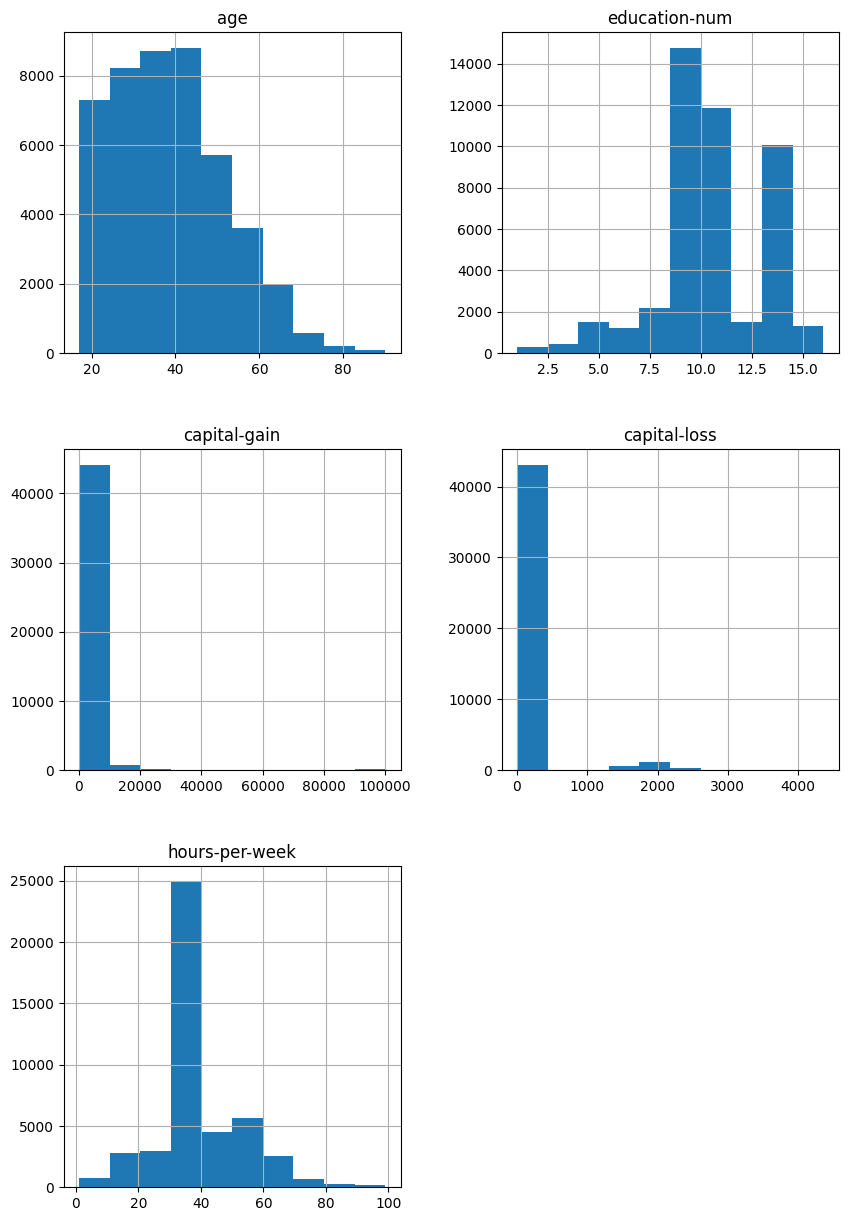

In [12]:
import matplotlib.pyplot as plt

numerical_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
data.hist(column=numerical_features, figsize=(10,15))
plt.show()

The "capital-gain" feature seems to have significant outliers.

In [13]:
max_capital_gain = data['capital-gain'].max()
print(max_capital_gain)
print(data[data['capital-gain'] == max_capital_gain].shape[0])

99999
229


It seems that the values for the "capital-gain" feature have been capped at 99,999 in the dataset. There are 229 rows in the data that have this capped max value. Since this is a capped value and not the true value and since these values are noticeable outliers, it is best to drop the rows that contain this max value.

In [14]:
data = data[~(data['capital-gain'] == max_capital_gain)]
print(data.shape)

(44993, 13)


#### Correlation

Analyzing the correlations between the features is helpful in the model building process.

In [15]:
data[numerical_features].corr()

,age,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,0.033835,0.115972,0.060178,0.100464
education-num,0.033835,1.000000,0.144173,0.083507,0.141353
capital-gain,0.115972,0.144173,1.000000,-0.051076,0.083500
capital-loss,0.060178,0.083507,-0.051076,1.000000,0.055378
hours-per-week,0.100464,0.141353,0.083500,0.055378,1.000000


All of the numerical features have low correlation with each other.

### Categorical Features

#### Correlation

For categorical features, the Cramér's V measure can be used to find the association between two features.

In [16]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_v(x, y):
    crosstab = pd.crosstab(x, y)
    chi2 = chi2_contingency(crosstab)[0]
    n = crosstab.sum().sum()
    k = min(crosstab.shape) - 1
    return np.sqrt(chi2 / n / k)

categorical_features = [c for c in data.columns if c not in numerical_features]
results = pd.DataFrame(index=categorical_features, columns=categorical_features)
for f1 in categorical_features:
    for f2 in categorical_features:
        results.loc[f1, f2] = round(cramers_v(data[f1], data[f2]), 3)

results

,workclass,marital-status,occupation,relationship,race,sex,us-native,income
workclass,1.0,0.077,0.218,0.088,0.06,0.142,0.053,0.158
marital-status,0.077,1.0,0.13,0.487,0.082,0.465,0.113,0.448
occupation,0.218,0.13,1.0,0.177,0.082,0.436,0.114,0.342
relationship,0.088,0.487,0.177,1.0,0.097,0.648,0.119,0.454
race,0.06,0.082,0.082,0.097,1.0,0.116,0.396,0.099
sex,0.142,0.465,0.436,0.648,0.116,1.0,0.009,0.214
us-native,0.053,0.113,0.114,0.119,0.396,0.009,1.0,0.038
income,0.158,0.448,0.342,0.454,0.099,0.214,0.038,1.0


There are several categorical features that have moderate association with each other. Out of these features, the "relationship" feature is of most interest. It has moderate association with both "marital-status" and "sex". This makes sense since this feature contains values based on marital status and if an individual is married, two of the possible values are "Wife" and "Husband" which is based on sex. Therefore, it is reasonable to drop this feature due to this redundancy.

In [17]:
data = data.drop(columns='relationship')
categorical_features.remove('relationship')

#### Distribution

It is also worthwhile to look at how the categorical data are distributed.

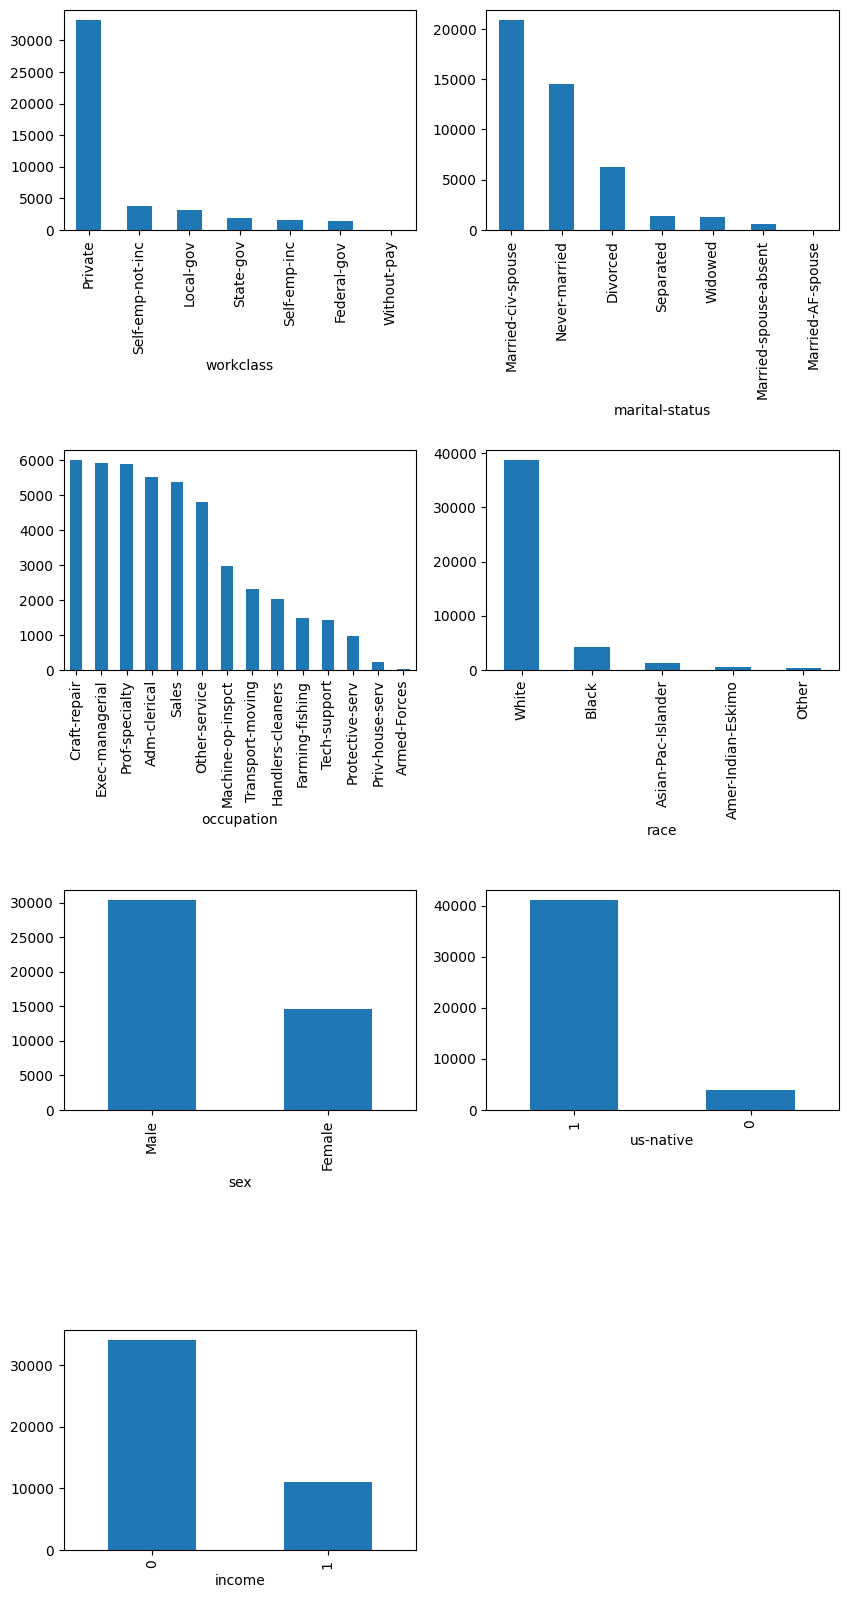

In [18]:
rows = 4
cols = 2
fig, axs = plt.subplots(rows, cols)
fig.delaxes(axs[3][1])
fig.set_figwidth(10)
fig.set_figheight(20)
fig.subplots_adjust(hspace=1.0)

for i in range(rows):
    for j in range(cols):
        if i*2+j == len(categorical_features):
            break
        data[categorical_features[i*2+j]].value_counts().plot(kind='bar', ax=axs[i][j])

### Conclusions

To conclude, from the exploratory data analysis, outliers were found for the "capital-gain" feature. These instances were removed from the dataset. The numerical features in the data all had low correlation with each other. Several categorical features had moderate correlation with each other. The "relationship" feature was dropped from the dataset due to the correlations with other features and redundancy. There were no other major issues based on the plots for the distributions of the features.

# Models

### Choice of Models

Since this is a binary classification task with a mix of numerical and categorical features, the following models will be considered:
- Logistic regression classifier
- Decision tree classifier
- Random forest classifier
- AdaBoost classifier

### Feature Engineering

In order for the categorical features in the dataset to work with the models mentioned above, one-hot encoding will be used to convert these features into binary features that take on either the value 0 or 1.

In [19]:
from sklearn.preprocessing import OneHotEncoder

data = data.reset_index(drop=True) # Reset indices since rows were dropped

features_to_encode = ['workclass', 'marital-status', 'occupation', 'race', 'sex']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(data[features_to_encode])
encoded_data = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())
data = data.join(encoded_data).drop(features_to_encode, axis=1)

print(data.shape)

(44993, 37)


#### Addressing Multicollinearity

By using `drop='first'` in the line `encoder = OneHotEncoder(sparse_output=False, drop='first')` above, both redundancy and multicollinearity is prevented since it drops one of the dummy variables when encoding variables into multiple dummy variables.

### Model Fitting and Hyperparameter Tuning

#### Training and Testing Split

The dataset will be split into two sets. A training set to fit the model and a testing set to evaluate the performance of the model.

In [21]:
from sklearn.model_selection import train_test_split

X = data.drop(columns='income')
y = data['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(33744, 36)
(33744,)
(11249, 36)
(11249,)


#### Logistic Regression Classifier

For the logistic regression classifier, the hyperparameters that will be considered deal with the regularization penalty. The hyperparameters are the penalty type and C, which is the inverse of the regularization strength. The penalty types that will be considered are L1 and L2 regularization. The values of C to be considered will range from $2^{-5}$ to $2^5$.

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

l1_acc = []
l2_acc = []
log_range = np.logspace(-5, 5, num=11, base=2)

for c in log_range:
    lrc = LogisticRegression(solver='liblinear', penalty='l1', C=c, random_state=1234).fit(X_train, y_train)
    y_pred = lrc.predict(X_test)
    l1_acc.append(accuracy_score(y_test, y_pred))
    
    lrc = LogisticRegression(solver='liblinear', penalty='l2', C=c, random_state=1234).fit(X_train, y_train)
    y_pred = lrc.predict(X_test)
    l2_acc.append(accuracy_score(y_test, y_pred))

In [23]:
print('L1 best accuracy:', np.max(l1_acc))
print('L1 best C:', log_range[np.argmax(l1_acc)])

print('L2 best accuracy:', np.max(l2_acc))
print('L2 best C:', log_range[np.argmax(l2_acc)])

L1 best accuracy: 0.8471864165703618
L1 best C: 8.0
L2 best accuracy: 0.8474531069428394
L2 best C: 4.0


L2 regularization and a value of 4.0 for C gives the best accuracy for the logistic regression classifier.

#### Decision Tree Classifier

For the decision tree classifier, the hyperparameter that will be considered is the maximum depth of the tree. First, a decision tree without a limit on the maximum depth will be fit.

In [25]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=1234).fit(X_train, y_train)
y_pred = dt.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Tree depth:', dt.get_depth())

Accuracy: 0.8156280558271847
Tree depth: 47


Without limiting the maximum depth, the decision tree classifier fits a tree with a depth of 47. Therefore, the range of values that will be considered for the maximum depth will be from 1 to 47.

In [26]:
dt_acc = []
for d in range(1, 48):
    dt = DecisionTreeClassifier(max_depth=d, random_state=1234).fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    dt_acc.append(accuracy_score(y_test, y_pred))

In [27]:
print('Best accuracy:', np.max(dt_acc))
print('Best maximum depth:', np.argmax(dt_acc) + 1)

Best accuracy: 0.8534980887189972
Best maximum depth: 9


A maximum depth of 9 gives the best accuracy for the decision tree classifier.

#### Random Forest Classifier

For the random forest classifier, the hyperparameters that will be considered are the number of trees and the maximum depth of the trees. The values that will be considered for the number of trees are 50, 100, 150, and 200. The values that will be considered for maximum depth are 10, 20, 30, 40, and 50 based on the results from fitting the decision tree classifier.

In [28]:
from sklearn.ensemble import RandomForestClassifier

rfc_acc = []
forest_sizes = [50, 100, 150, 200]
max_depths = [10, 20, 30, 40, 50]
best = (0, 0, 0.0) # (k, d, acc)

for k in forest_sizes:
    k_acc = []
    for d in max_depths:
        rfc = RandomForestClassifier(n_estimators=k, max_depth=d, random_state=1234).fit(X_train, y_train)
        y_pred = rfc.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        if acc > best[2]:
            best = (k, d, acc)
        k_acc.append(acc)
    rfc_acc.append(k_acc)

In [29]:
print('Best accuracy:', best[2])
print('Best number of trees:', best[0])
print('Best maximum depth:', best[1])

Best accuracy: 0.8631878389190151
Best number of trees: 100
Best maximum depth: 20


100 trees and maximum depth of 20 give the best accuracy for the random forest classifier.

#### AdaBoost Classifier

For the AdaBoost classifier, the hyperparameter that will be considered is the number of estimators or the number of iterations in the boosting. The values to be considered for the number of estimators range from 1 to 200.

In [30]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(n_estimators=200, algorithm='SAMME', random_state=1234)
abc = abc.fit(X_train.values, y_train.values)

In [31]:
abc_acc = [acc for acc in abc.staged_score(X_test.values, y_test.values)]
print('Best accuracy', np.max(abc_acc))
print('Best number of estimators', np.argmax(abc_acc) + 1)

Best accuracy 0.8542092630456041
Best number of estimators 173


Using 173 estimators gives the best accuracy for the AdaBoost classifier.

# Results and Analysis

The best accuracy achieved for the logistic regression classifier is 0.8475 with L2 regularization and C value of 4.0. The following plot shows the accuracies as the C value changes for L1 and L2 regularizations.

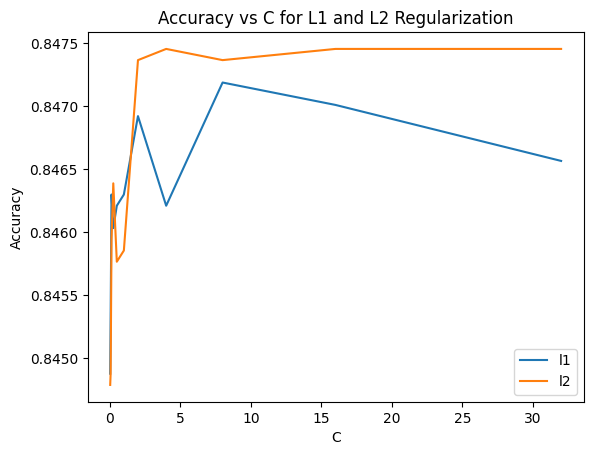

In [32]:
plt.plot(log_range, l1_acc, label='l1')
plt.plot(log_range, l2_acc, label='l2')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C for L1 and L2 Regularization')
plt.legend()
plt.show()

The best accuracy achieved for the decision tree classifier is 0.8535 with a maximum depth of 9. The following plot shows the accuracies as the maximum depth changes.

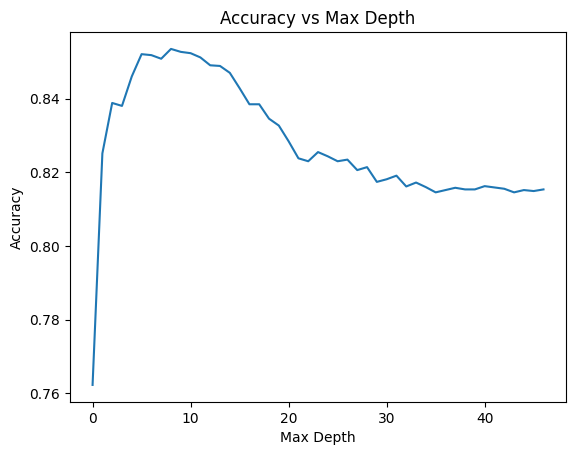

In [33]:
plt.plot(dt_acc)
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth')
plt.show()

The best accuracy achieved for the random forest classifier is 0.8632 with 100 trees and a maximum depth of 20. The following plot shows the accuracies as the maximum depth changes for random forest classifiers with varying number of trees.

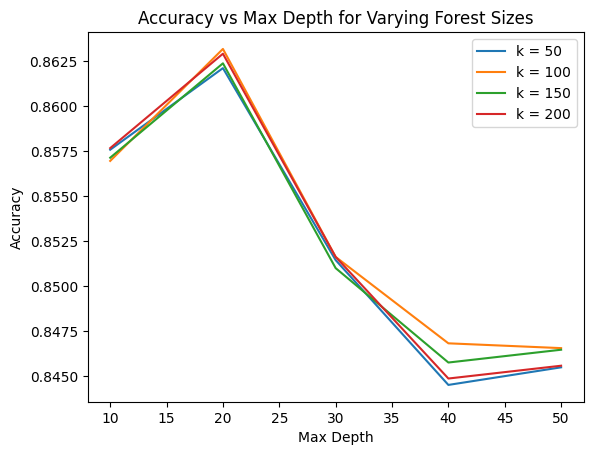

In [34]:
for i in range(len(forest_sizes)):
    plt.plot(max_depths, rfc_acc[i], label=f'k = {forest_sizes[i]}')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth for Varying Forest Sizes')
plt.legend()
plt.show()

The best accuracy achieved for the AdaBoost classifier is 0.8542 with 173 boosting iterations. The following plot shows the accuracies over the boosting iterations.

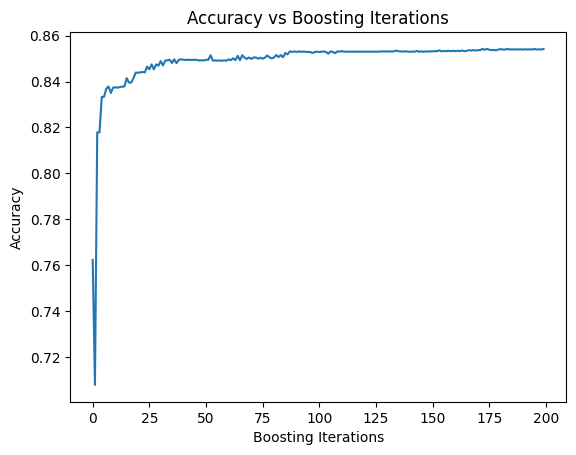

In [35]:
plt.plot(abc_acc)
plt.xlabel('Boosting Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Boosting Iterations')
plt.show()

The following table summarizes the best accuracies achieved for each type of classifier.

| Classifier | Best Accuracy |
|:--:|:--:|
| Logistic Regression | 0.8475 |
| Decistion Tree | 0.8535 |
| Random Forest | 0.8632 |
| AdaBoost | 0.8542 |

# Discussion and Conclusion

From conducting the analysis on this dataset, it was observed that a classifier with good accuracy can indeed be fit to the features in this dataset to predict whether an individual's annual income is greater than 50,000. The random forest classifier is the classifier that was able to achieve the best accuracy of 0.8632.

A limitation of building a model using this dataset is the presence of many multiclass categorical features in the dataset. If the dataset included exclusively numerical features, it is likely that classifiers that can achieve higher accuracies could be trained.

The best accuracy achieved could possibly be improved by utilizing methods other than one-hot encoding to deal with the categorical features in the dataset. Additionally, considering other hyperparameters or different ranges of values for the hyperparameters could also improve the accuracies of the classifiers.